OSE scentific computation final report  WS 2020/2021 Bonn University
Title
author: Po-Tse Cheng

In [1]:
# import custom functions
from tools.auxiliary import*
from tools.GSSA_1_agent import*
from tools.GSSA_countries import*

In [2]:
# todo 
#- recomment the comments
# change some wordings, so many "followings"
# make table of content
# intro sucks (for now)
# make sure the number of equation is correct

What you can expect in this notebook:

- All of the matlab codes from the original authors have been translated into python, including Appendix.
- Besides of the representitive agent model, a multicountry model purposed by the paper is also implemented in python.
- Instead of presenting the results in merely tables, I construct figures as they are more intuitive in my opinion.

What is the caveat:

- Two proximation methods included in GSSA, namely LAD-DP and RLAD-DP is not implemented

This notebook contains the python implementation of the General Stochastic Simulation Algorithm (GSSA), developed by Kenneth L. Judde et. al (2011). 

### 
Table of contents here

## Introduction

A better text here
There are three mainstream methods for solving a dynamic stochastic economics model: projection methods, perturbation methods, and stochastic simulation methods. Each of these methods have 

We will be focusing on the stochastic model with the goal of 

-----
Work in process: Maybe it make sense to first talk about the GSSA then look at the stuff of stability and accuracy
This notebook is constructed as the following: We will first look at the theorethical background for stochastic model, including potential solution of addressing the undesired properties. Then we will take a closer look at GSSA's mechanisms. In chapter 4, we will showcase the GSSA in a multi-country framework. Lastly, we conclude this notebook in chapter 5.

## Background

In this section, we will first set up a classical representitive agent model to further discuss the advantages of stochastic simulation methods. We will then show the mechanism of PEA, and further discuss how GSSA evolves and surpass the precursor.

### The Representitive Agent Model

Consider an agent that faces intertemporal utility-maximisation problem:

\begin{align*}



\max_{\{k_{t+1}, c_{t}\}_{t=0,...,\infty}}&E_{0}\sum^{\infty}_{t=0}\beta^{t}u(c_{t}) \tag{1} \\
s.t.\quad &c_{t}+k_{t+1}=(1-\delta)k_{t}+a_{t}f(k_{t}), \tag{2}\\
&\ln a_{t+1}=\rho\ln a_{t}+\epsilon_{t+1}, \epsilon_{t+1}\sim \mathcal{N}(0,\,\sigma^{2}) \tag{3}\\
&u^{'}(c_{t})=E_{t}\{\beta u^{'}(c_{t+1}) [1-\delta+a_{t+1}f^{'}(k_{t+1})]\} \tag{4}


\end{align*}

  Where $u(\boldsymbol{\cdot})$ represents the utility function, $E_{t}$ on the other hand denotes the expectation operator for the information given at time $t$.  $c_{t}$, $k_{t}$, $a_{t}$ stands for consumption, capital, and productivity level respectively. $f(\boldsymbol{\cdot})$ describes the production function. $\beta \in (0,1)$ denotes the discount factor; while $\delta \in (0,1]$ and $\rho \in (-1,1)$ represents depreciation of capital and autocorrelation coefficient of the productivity level. $\sigma \geq 0$ stands for the standard deviation of the productivity shock. Notice that during $t=0$ both $k_{0}$ and $a_{0}$ are given. The solution to the stochastic model needs to satisfy the Euler equation (4), while also both transition equations (2) (3). Our objective will be trying to obtain both policy and consumption function, which denotes as $K(\boldsymbol{\cdot})$, $C(\boldsymbol{\cdot})$. Both solutions also need to be able to represent as a Markov equilibrium such that $k_{t+1}= K(k_{t},a_{t})$ and $c_{t}=C(k_{t}, a_{t})$.

### Why Stochastic Simulation Models?

The biggest advantage of using stochastic simulation method is it only considers solutions that are part of the state space visited in equilibrium. In other words, solutions can only be from the space created by simulations, which translates into a higher probability to be the right answers. Taking the closed-form solutions from the representitive agent model, we can see that in Figure (1) the ovel shape from the solutions does not occupy the whole rectangular space. To be even more precise, the solutions take around 79% of the space or 21% smaller than the original space.

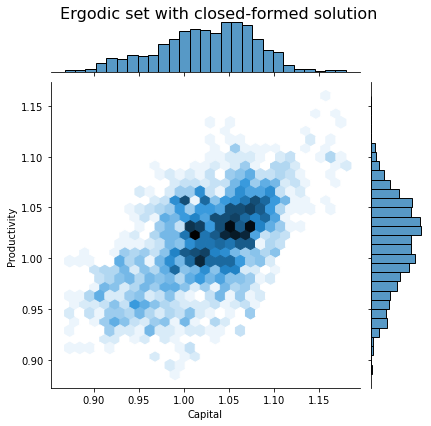

In [3]:
Figure1()

This occupying ratio quickly decreases as the dimension increases. Consider $\nu^{d}$ denotes the ratio of a $d$-dimensional hypersphere to $d$-dimensional hypercube with both diameter set to 1. The general form of the ratio can be express as follow:

\begin{align*}
\nu^{d}=
\begin{cases}
      \frac{(\pi/2)^{(d-1)/2}}{1\cdot3\cdot,...,d} & \text{for $d=1,3,5,...$}\\
      \frac{(\pi/2)^{d/2}}{2\cdot4\cdot,...,d} & \text{for $d=2,4,6,...$}\\
\end{cases}     
\end{align*}

We can observe that the ratio $\nu^{d}$ decrease rapidly with the increase of dimension. Stochastic simulation methods therefore have the advantage of not calculating the whole sets of potential candidates, which translate into lower computational cost. The larger the dimension, the larger the cost save. Another great perk is that given the model only consider relevant domain, via fitting the polynomials one is able to achieve great accuracy than conventional projection methods. Maliar et al.(2010) further provide evidence to the latter claim.

### Problems with Stochastic Methods

Despite the promising theoretical perspectives, most conventional simulation models have disappointing results in real practices. Not only are they not able to obtain high accuracy as projection methods, it is also difficult for them to reach numerical stability in higher polynomials. Let us consider a generic stochastic algorithm for model solving:
<ol>
 <li>Guessing the policy or value function</li>
 <li>Simulate the time series solution</li>
 <li>Use simulated solution to recompute the guess</li>
 <li>Repeat 2 and 3 until converge</li>
</ol>
Notice that during step 3 the algorithm will do both regression approximation and intergration, as the former aims to fix an approximate function while the latter evalutes the conditional expectations. It is also during this step where the weaknesses are formulated. Simulation methods often suffer from low numerical stability, namely it is difficult for the calculated solutions to converge. The authors further point out the unstability is the side effect of the the high correlation among the polynomial degrees. This means standard least square methods are likely to fail due to low stability. Poor accuracy stems from traditional Monte-Carlo integration method, as Judd et al.(2011) shows more promising accuracy if one choose alternative methods such as Gauss-Hermite.

### From PEA to GSSA

After discussing the potential strengths and weekness of simulation methods, let's refocus on how simulation methods approach the representative agent problem. In particular, we will be focusing on the Parameterized Expectations Algorithm (PEA) by Marcelt et al. (1988). PEA serves as the precursor the GSSA, and most importantly take advantage of ergodic solutions. It proceeds as following:

1. Construct a flexible functional form from equation (4)
* Notice that the $b$ below are a series of approximate coefficients for the real function, that we wish to obtain
\begin{align*}
u^{'}(c_{t})=E_{t}\{\beta u^{'}(c_t+1)[1-\delta+a_{t+1}f^{'}(k_{t+1})]\} \equiv \psi(k_{t}, a_{t}; b)= \exp (b_{0}+ b_{1} \ln a_{t}+,...,b_{n} \ln (a_{t})^{l}) \tag{5}
\end{align*}
2. Plug equation (5) into to equation (2) to express future capital $k_{T+1}$
\begin{align*}
k_{t+1} \equiv (1-\delta)k_{t}+ a_{t}f(k_{t})-\frac{1}{u^{'}}[\psi(k_{t}, a_{t}; b)]  \tag{6}
\end{align*}
3. Simulate the set $\{c_{t}, k_{t+1}\}_{t=0,...,T}$ with equation (6), where $T$ stands for the simulation length
* Fix $b$ to some abitrary set
* $\{a_{t}\}_{t=1,...,T}$ is pre-defined
\begin{align*}
y_{t} \equiv \beta u^{'}(c_{t+1}) [1-\delta+ a_{t}f^{'}(k_{t+1})] \tag{7}
\end{align*}
4. By combining equation (7) and (5) we can get $y_{t}=\psi(k_{t}, a_{t}; b)+\epsilon$, employ nonlinear least square regression to solve $\hat b$
5. compute the next iteration input $b^{(p+1)}$ with fix-point iteration
* $\zeta$ is the damping parameter, where $\zeta \in (0,1]$
\begin{align*}
b^{(p+1)}=(1-\zeta)b^{(p)} + \zeta \hat b \tag{8} 
\end{align*}

PEA suffers from the exact two afore-mentioned drawbacks. Firstly, in theory PEA is able to handle high polynomials in equation (5), the outputs however are generally numerically unstable. We can see this by going through the later work of Marcet, where he removes $b_{5}\ln k_{t} \ln a_{t}$ in the 2nd polynomial term in order to achieve convergent. Secondly, the accuracy of PEA is low, namely the accuracy does not increase with higher polynomials. The goal of the GSSA, is to overcome these two obstacles at once, as it is waste of effort increasing the numerical stability of higher polynomials if they do not yield better accuracy, while there is also no point of attaining a higher accuracy in higher polynomials if it is not numerically stable. Let us now examine the difference of equation (5) in GSSA compared to PEA. Instead of incorporating the original exponential $\psi$, GSSA uses the flexible functional form as the following:

\begin{align*}
\psi(k_{t}, a_{t}; b)=  b_{0}+ b_{1} \ln a_{t}+,...,b_{n} \ln (a_{t})^{l} \tag{9}
\end{align*}

The main reason to abandon the original non-linear method is to reduce the complexity of obtaining $b$, while simultaneously introducing other regression methods that are capable of handling collinear data. This approach can drastically improve the numerical stability. Under the GSSA framework, LS methods using singular value decompsition (SVD) and least-absolute deviations (LAD) are possible. GSSA are also design in such a way that one can simply switch between integration methods. In section ?, we will see that the results of Monte-Carlo are indeed unremarkable.

So how do we solve the 1 agent problem with GSSA? We will be using 2 particular tools to obtain our solutions. Similar to Marcet et al. (1988), we will incorporate the flexible functional form $\psi(\boldsymbol{\cdot} ;b)$ to approximate the original policy function $K(\boldsymbol{\cdot})$. $K(\boldsymbol{\cdot})$ is therefore expressed with: (need to also say Marcet approximate the stuff on utility function, while they do it on policy funtion)

\begin{align*}
\psi(k_{t}, a_{t}; b) \approx K(k_{t},a_{t})=k_{t+1} \tag{10}
\end{align*}

Now consider the second tool: Fixed point construction. Via rewriting equation (4), we obtain the follows:

\begin{align*}
&u^{'}(c_{t})=E_{t}\{\beta u^{'}(c_{t+1})[1-\delta+a_{t+1}f^{'}(k_{t+1})]\} \\
&\equiv  1=E_{t}\{\beta\frac{u^{'}(c_{t+1})}{u^{'}(c_{t})} [1-\delta+a_{t+1}f^{'}(k_{t+1})]\} \\
&\equiv k_{t+1}= E_{t}\{\beta\frac{u^{'}(c_{t+1})}{u^{'}(c_{t})} [1-\delta+a_{t+1}f^{'}(k_{t+1})]k_{t+1}\} \tag{11}
\end{align*}

Given that the first derivative of utility function $u^{'}(c_{t})$ in the Euler equation can never be 0, equation (10) holds under any condition. By combining both equation (10) and equation (11) (by subtitution), we will be able to solve the stochastic model by computing the conditional expectation.

## Mechanisms of GSSA

In this section, we will be looking into the mechanisms of the GSSA. Following the original authors, we will break down the whole algorithm into two parts: Stage 1 and Stage 2. The purpose of Stage 1 aims to find suitable candidates, while Stage 2 conducts the accuracy test by using a new set of test points (can be another set of random draw or deterministic set of points) independent to the solution.

### GSSA Stage 1

1. Initialisation

* Parameters set up 
* Initial states for $k_{0}$ and $a_{0}$
* Define simulation length $T$

2. At iteration $p$ Use $b^{(p)}$ to simulate the model for $T$ periods, in this case it is capital $k_{t+1}$ and consumption $c_{t}$ as describe in the markov equilibrium
* Capital
\begin{align*}
k_{t+1}=\psi(k_{t},a_{t};b^{(p)})
\end{align*}

* Consumption
\begin{align*}
c_{t}=(1-\delta)k_{t}+ a_{t,j}f(k_{t})-k_{t+1,j}
\end{align*}


3. Define $y_{t}$ to be the approximation of conditional expectation in equation (11) with given $J$ integration nodes $\{\epsilon_{t+1,j}\}_{j=1,...,J}$ and weights $\{\omega_{t+1,j}\}_{j=1,...,J}$

\begin{align*}
y_{t}= \sum^{J}_{j=1}\{\omega_{t,j}\cdot(\beta\frac{u^{'}(c_{t+1,j})}{u^{'}(c_{t})}[1-\delta + a_{t+1,j}f^{'}(k_{t+1}) ]k_{t+1}) \} \tag{12}
\end{align*}


Notice that $a_{t+1,j}$, $k_{t+2,j}$, and $c_{t+1,j}$ are calculated as following:

\begin{align*}
\begin{cases}
a_{t+1,j}= a^{\rho}_{t}exp(\epsilon_{t+1,j}) \\
k_{t+2,j} \equiv \psi(k_{t+1}, a^{\rho}_{t}exp(\epsilon_{t+1,j});b^{(p)} ) \\
c_{t+1,j} = (1-\delta)k_{t+1}+ a_{t+1,j}f(k_{t+1})-k_{t+2,j}
\end{cases}
\end{align*}


4. Find the $\hat b$ that minimise the error term with chosen approximation method, depending on whether if it is the initial guess or updating the solution
\begin{align*}
y_{t}=\psi(k_{t},a_{t};b)+\epsilon_{t} \tag{13}
\end{align*}

5. Check convergence, jump out of stage one if satisfied
\begin{align*}
\frac{1}{T}\sum^{T}_{t=1}|\frac{k^{(p)}_{t+1}-k^{p-1}_{t+1}}{k^{(p)}_{t+1}}| < \varphi
\end{align*}


Where the D inside the code denotes the polynomial degree and kdamp stands for damping parameter for iteration on the coefficients of the capital policy functions. The convergence parameter $\varphi$ depends on both values. @rewrite

6. Compute $b^{p+1}$ for the next iteration similar to equation (8)
\begin{align*}
b^{(p+1)}=(1-\zeta)b^{(p)} + \zeta \hat b 
\end{align*}

<div class="alert alert-block alert-success">
<b>Side note:</b> Notice that within Stage 1, GSSA will first employ a 1-node Monte Carol intergration method for the initial guessing. Afterwards, within the scope of Stage 1, GSSA will update the solution with regards to each polynomial based on the selected regression method, integration method, and polynomials.
</div>

### GSSA stage 2

The stage 2 of GSSA is a self-contained benchmarking stage for the results from stage 1, to ensure the results only have errors with low economical impact. Stage 2 measures both the unit-free maximum and mean errors with another independent set of simulations or deterministic set. The prerequisite will be that the number of testing samples $T^{test}$ needs to be either equal or larger than the original simulation $T$. Let us denote the new testing set as $\{a_{i},k_{i}\}_{i=1,...,T^{test}}$, and the theoretical notation for stage 2 is as follows:
\begin{align*}
\epsilon_{k_{i},a_{i}}=E_{i}\{\beta\frac{u^{'}(c_{i+1})}{u^{'}(c_{i})}[1-\delta+a_{i+1}f^{'}(k_{i+1})]\}-1
\end{align*}
One can immediately see that the test itself is another manupulation of the original Euler equation (4).

### GSSA result showcase

Need to mention here more discussion will be given in future sections
I will now demonstrate the results from using GSSA. In this scenario, I set the length of simulation to 10000 observations and choose RLS-TSVD as my regression method. Furthermore, I pick 10-node Gauss-Hermite quadrature as my integration methods. The accuracy from stage 2 are measured by 10200 observations independently. Below are the results:

In [4]:
showcase_result = GSSA_ShowcaseResult()
showcase_result

,Maximum Error,Mean Error,Time,Error Time,Polynomial Degree,Total Time,Rounded Total Time,Original Mean Error,Original Max Error
0,-3.366134,-4.358702,37.023666,0.782905,1,37.806571,37.81,4.378225e-05,4.303938e-04
1,-4.883611,-6.118154,61.512884,0.812831,2,62.325715,62.33,7.618090e-07,1.307343e-05
2,-5.951989,-7.481158,84.273132,1.508959,3,85.782091,85.78,3.302497e-08,1.116891e-06
3,-7.021109,-8.716910,128.025651,1.012234,4,129.037885,129.04,1.919067e-09,9.525574e-08
4,-7.178640,-8.893005,180.780177,1.150921,5,181.931098,181.93,1.279368e-09,6.627663e-08


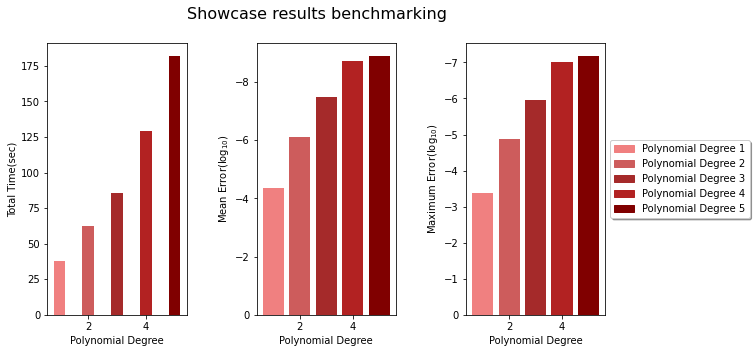

In [5]:
Figure2(showcase_result)

The results of the final output is remarkable. We can see that the accuracy increase with the polynomials

Not only does it achieve an astonishing average $10^{-9}$ in polynomial degrees 4 and 5, there are no longer an 

<div class="alert alert-block alert-success">
<b>Short conclusion:</b> These results further confirm that GSSA overcome the two main problems from the original PEA: (1) numerical instability and (2) low accuracy in higher polynomials.
</div>

## Weakness Identifying and Solving (need better title here)

As highlighted in the previous section, in order to fully reach the potential of higher accuracy in higher polynomials, both numerical instability and low accuracy need to overcome the same time. In this section, we will be discussing the cause of both issues for general simulation methods, then provide theoretical solutions. In each subsection we will also show the benchmarking figures with each particular methods.

### Ill-conditioned LS problems

Instability issue are in general inavoidable for simulation methods, as higher polynomials stem from lower polynomial. We will use the frame work of representative agent model to identify this issue. We start by rewriting equation (9) into the following:

\begin{align*}
\psi(k_{t},a_{t};b) = \sum^{n}_{i=0}b_{i}\psi_{i}(k_{t},a_{t}) 
\end{align*}

Which combining with equation (13) implies the following equation:

\begin{align*}
y = Xb+\epsilon \tag{14}
\end{align*}

Notice that all parameters represent a vector, such that $y\equiv (y_{0},y_{1},...,y_{T-1})^{\top}\in \mathbb{R}^{T}$, $x\equiv [1^{T},x_{1},...,x_{n}]\in \mathbb{R}^{T\times(n+1)}$, and $\epsilon \equiv (\epsilon_{0},\epsilon_{1},...,\epsilon_{T-1})^{\top} \in \mathbb{R}^{T}$. We can therefore obtain the estimator $\hat b$ with OLS that minimise the error term:
\begin{align*}
\hat b = (X^{\top}X)^{-1}X^{\top}Y \tag{14}
\end{align*}

We will now define a measurement that measures the degree of ill conditioning of $X^{T}X$:
\begin{align*}
k(X^{\top}X)\equiv \frac{\lambda_{1}}{\lambda_{n}}
\end{align*}
$\lambda_{1}$ denotes the largest eigenvalue by decomposing $X^{\top}X$, while the $\lambda_{n}$ represents the smallest eigenvalue. If $k(X^{\top}X)$ is large, one can expect the value to be close to singular, which implies the $(X^{\top}X)$ in equation (15) is not invertible. There are two main reasons why the linear model is ill-conditioned: (1) Scaling problem and (2) Multicollinearity. I will use the examples from the authors to show how perturbation from these two reasons will impact the numerical stability of the coefficients:

- Scaling:
Assume $X = \begin{bmatrix} 1 & 0 \\ 0 & \phi \end{bmatrix}$, where $\phi$ (is not zero) and $k(X^{\top}X) = (\frac{1}{\phi})$. Suppose there are some perturbation that causes $y$ to be $y = (\epsilon_{1},\epsilon_{2})^{\top}$. The OLS solutions are:
\begin{align*}
\begin{cases}
\hat b_{1} = \epsilon_{1}\\
\hat b_{2} = \frac{\epsilon_{2}}{\phi}
\end{cases}
\end{align*}

- Multicollinearity:
Assume now $X = \begin{bmatrix} 1+\phi & 1 \\ 1 & 1+\phi \end{bmatrix}$ then $k(X^{\top}X) = (1+\frac{2}{\phi})^{2}$. If $y$ is expose to some error terms, such that $y = (\epsilon_{1},\epsilon_{2})^{T}$ then the solutions become:
\begin{align*}
\begin{cases}
\hat b_{1} = \frac{1}{\phi}[\frac{\epsilon_{1}(1+\phi)-\epsilon_{2}}{2+\phi}]\\
\hat b_{2} = \frac{1}{\phi}[\frac{\epsilon_{2}(1+\phi)-\epsilon_{1}}{2+\phi}]
\end{cases}
\end{align*}

We can observe that in both cases, the solutions are proportional to $\frac{1}{\phi}$ and is related with $k(X^{T}X)$. This means that both problems will magnify the impact of the perturbution. In the case of our simulation model, the magnifying property will accumulate through the iterations and results in erratic jumps in coefficients, not to mention some numerical errors such as rounding. This ultimately leads to the non-converging regression solutions, therefore it is essential for the GSSA model to employ methods that can tackle this undesired property.

### Stability enhancement:

GSSA employs least squared singular value decomposition (LS-SVD), least absolute deviation (LAD), and principal component method as the main regression methods. These methods combined with regularisation, not only produce accurate results by penalising large deviations, but are also capable of handling ill-conditioned data. This will therefore allow us to increase the stability. Moreover, different types of polynomial families will also affect the stability.

<div class="alert alert-block alert-success">
<b>Side note:</b> All regularised methods include the normalisation of the variables, and can be manually turn on in GSSA for OLS, LS-SVD, and LAD-PP. The normalisation aims to address the scaling problem described in section (?). This is done by: (1) Assuming both $y$ and $X$ have a mean of 0 and unit standard deviation. (2) Run the regression to get the solutions. (3) Restore the "real" solutions by using the sample mean and sample standard deviation. For more mathematic details please consult Judd et al.(2011)
</div>

#### Polynomial Families 

We will first look at the potential impact of different type of polynomial families. This is essential, as GSSA relys on a basis polynomial family to construct $X$ and also for parameterising the target policy function. Under the GSSA framework, two types of polynomial families are considered: (1) Ordinary polynomials (2) Hermite Polynomials. Ordinary polynomials $O_{m}(x)$ are consist of raising the power of the variable with corresponding degree. For instance, $O_{3}(x)$ denotes $x^{3}$. The problem with the oridnary polynomial family is the high correlation among high polynomials. This is further illustrated in the figure below as we can see it is impossible to tell the difference between different polynomials in range -1 to 1. Hermite polynomials on the other hand are constructed as the following:

\begin{align*}
\begin{cases}
H_{0}(x)=1\\
H_{1}(x)=X\\
H_{n}(x)=xH_{n}(x)-nH_{n-1}(x)
\end{cases}
\end{align*}

The biggest advantage of such construction is the polynomials are no longer highly correlated. However it is worth mentioning that Hermite polynomial family itself is not enough to rule out the entirity of the multicollinearity problem, as it only reduces the intensity of the correlation among polynomials. One example is the high correlation between $(k_{t}, a_{t})$ in the second polynomial: 


\begin{align*}
\begin{cases}
H_{2}(k_{t})= k_{t}^{2}-1\\
H_{2}(a_{t})= a_{t}^{2}-1
\end{cases}
\end{align*}

Therefore, in order to overcome multicollinearity, it is a unavoidable to utilise regression methods specific for solving multicollinear problems.

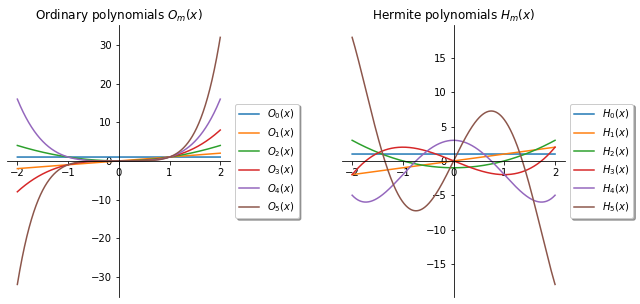

In [6]:
Figure3()

#### LS approach

(add sth here too)

LS-SVD

This method sidesteps the need of calculating $X^{\top}X$ explicity by decomposing $X$ such that $X=USV^{\top}$. The $U$ stands for unitary matrix, $S$ denotes non-negative real number rectancular diagonal matrix, while $V$ is another unitary matrix. $\hat b$ is now therefore $\hat b = VS^{-1}U^{\top}y$. Under the assumption that $X^{\top}X$ are ill-conditioned, it is possible that both $X$ and $S$ are well-conditioned, therefore the problem is solvable. 

(maybe can add more stuff here)

RLS-Tikhonov 

Tikhonov regularisation rewrites the original $b \in arg_{min}\lVert y-Xb \rVert$ into $b \in arg_{min}\lVert y-Xb \rVert^{2}_{2}+\eta \lVert b \rVert^{2}_{2}$. The goal of this method, is to transform the original ill-conditioned problem into a simplier ill-conditioned problem. This mechanism is also classified as a shrinkage method as compared to its counterparts, Tikhonov shrinks the norm for the coefficients. The $\eta$ in the second term is the penalty parameter, where the larger the $\eta$ is, the greater the shrinkage. The estimator will therefore become $\hat b(\eta) = (X^{\intercal}X+\eta I_{n})^{-1}X^{\top}y$. One can immediately recognise that Tikhonov regularisation add the term $\eta I_{n}$ to the original $(X^{\top}X)$, this reduce the probability of $(X^{\top}X)$ of being singular, which in turn results in failure of calculation. Despite the advantage of tackling ill-conditioned problems, Judd et al. (2011) notify that the estimator $\hat b(\eta)$ can be biased with a large $\eta$. However, Hoerl and Kennard's findings show that it is possible to achieve a smaller mean square than the original OLS with the correct $\eta$. In Judd et al. (2011), they select the $\eta$ for the GSSA manually by iterating over different values of potential $\eta$.

RLS-TSVD

Regularised LS using truncated SVD (RLS-TSVD) are a modified version of LS-SVD with ideas borrowed from principal component method(PCM). To see how it works, we will need to first consider how PCM tackle with multicollinearity. Consider the a linear transformation of the SVD's $X \in \mathbb{R}^{T \times n}$ such that $Z\equiv XV$. Both $Z$ and $V$ are the unitary matrices, and $z_{1},z_{2},..,z_{n}$ vectors are the principle components of the original $X$, with the following property:
$$
\begin{align}
z^{\top}_{i^{'}}z_{i} = 
\begin{cases}
    0 & \text{If $i^{'} = i$} \\
    s^{2}_{i} & \text{If $i^{'} \neq i$} \\
\end{cases}
\end{align}
$$

Where $s_{i}$ denotes the singular value, and each $z_{i}$ have the mean of zero and variance of $\frac{s_{i}^{2}}{T}$. Given that SVD method automatically orders the singular values from large to small, $z_{1}$ will have the largest singular values and $z_{n}$ will have a close to zero variance. If in partcular the $z_{n}$ is indeed zero, this means $x_{1},...,x_{n}$ will be linear dependent. This is where the truncation comes into play. By eliminating the elements from the $k$ to $n$, we can ensure that $x_{1},..,x_{k}$ are not ill-conditioned. The cost of this method is that we can only approximate the origin $Xb$ with only part of itself, where the disregards may contain useful information:
$$
\begin{align}
Xb=XVV^{-1}b \approx XV^{r}(V^{r})^{-1}b_{k}=Z^{r}\vartheta^{r} \tag{16} \\ 
\end{align}
$$
Equation (16) further transform the question into $\hat \vartheta^{r} \in arg_{min}\lVert y-Z^{r}\vartheta^{r} \rVert$. By using any LS or RAD methods, we can get our estimator $\hat \vartheta^{r}$. Afterwards, we can recover $\hat b(k)$ with $\hat b (k)= V^{r}\hat \vartheta^{r}$. Now, instead of using PCM to remove components that are collinear, we use the truncated SVD process directly, such that $X^{r} \equiv U^{r}S^{r}(V{r})^{\top}$. By using the theorm of Eckart and Young(1936), which states $X^{r}$ is the close rank approximation for $X$, we arrive to the equation $y=x^{r}b(r)+\varepsilon$. We can then rewrite the term $x^{r}b(r)$ to $U^{r}S^{r}\vartheta^{r}$ by substitution. This implies $y=U^{r}S^{r}\vartheta^{r}+\varepsilon$ and we can again use any methods to get our estimator $\hat \vartheta^{r}$ then use it to recover $\hat b(r)$. Our final estimator is describe as $\hat b(r)=V^{r}(S^{r})^{-1}(U^{r})^{\top}y$ where if $r=n$ then the answer will be the same as LS-SVD. RLS-TSVD biggest advantage, when compared to other LS methods, is that it is effectively a shrinkage method without any additional scalling or additions.

---

In the following figure, I include the implementation of different LS methods with a 1 node Monte-Carlo integration. The simulation length is 3000 observations, while unit-free Euler equation errors (in $\log_{10}$ units) depends on a stochastic simulation of 10,000 observations. Notice that different types of polynomial families are also included.

In [7]:
# One can of course change the True to False here, the code should have no problem running through.
# It will take some time though.
result1, result2, result3 = Result_agent(cache=True)

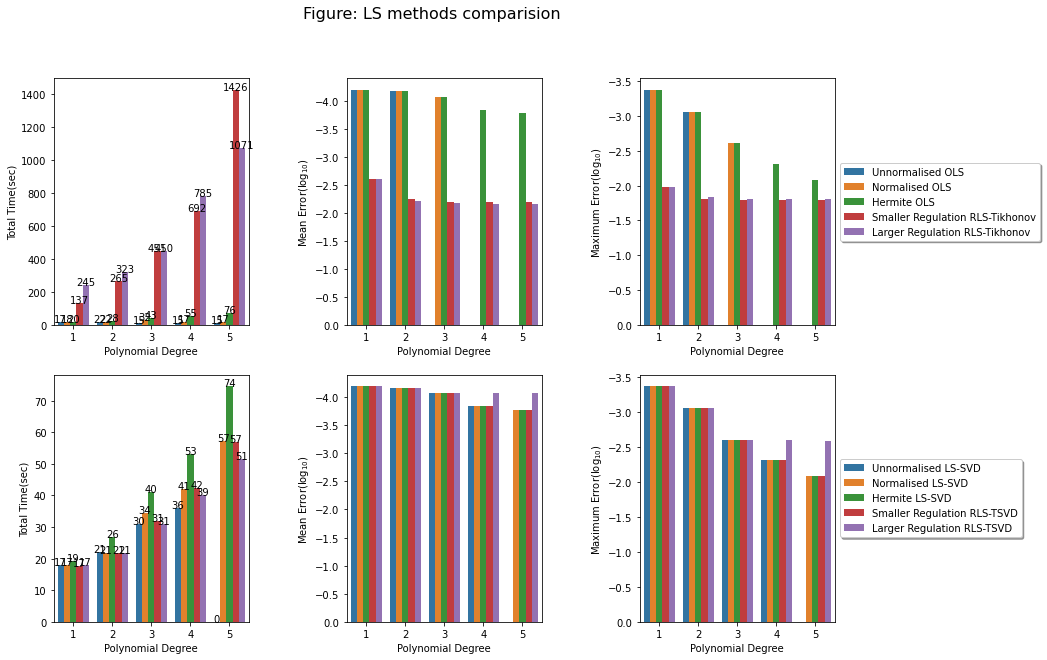

In [8]:
LS_Figure(result1, result2)

Some remarks here explaining the figures

#### LAD approach

This problem has n + T unknowns. We argue that it is not the most
suitable for a numerical analysis. (LAD)

LAD methods in general does not depend on the term $X^{T}X$ therefore are able to avoid the trap of multicollinearity. A basic LAD method solves the following optimising problem:
\begin{align*}
b \in argmin 1_{T}^{\intercal}\left| y-Xb \right| 
\end{align*}

Which can be transfer into a linear programming problem:
\begin{align*}
&min_{g,b} 1_{T}^{\intercal}g \tag{17}\\ 
&s.t. \quad -g 	\leq y-Xb \leq g 

\end{align*}

LAD methods in general are robust against outliers, when comparing to the LS counterparts. This is mainly because LAD does not square the errors for minimisation. Moreover, LAD is flexible and less computational expensive for additional linear restrictions. Nevertheless, LAD also possess two disadvantages, namely the solutions from LAD may not be continous and LAD are more computational expensive than LS. In this section, we will be dicussing a particular branch of LAD, namely the LAD primal problem (LAD-PP) purposed by Charnes et al.(1955).

LAD-PP
The primal problem changes the original $y-Xb$ into a canonical linear programming form. To see how it works, we start by rewriting the equation (13) as follows:
\begin{align*}
y_{t}-\sum^{n}_{i=0}b_{i}x_{ti}=v^{+}_{t}-v^{-}_{t}
\end{align*}

The $t$ represent the $t$ element of the given $i$th vector. The two nonnegative variables, $v^{+}_{t}$ and $v^{-}_{t}$ represent the magnitude above and below the fitting line of $X\hat b$ respectively. We can now follow the similar procedure as equation (17) to transfer this into a linear programming problem:
\begin{align*}
v^{+},v^{-},b \in &argmin 1^{\top}_{T}v^{+}+1^{\top}_{T}v^{-}\\
&s.t. \quad v^{+}-v^{-}+Xb=y\\
&v^{+}\geq 0, \quad v^{-}\geq 0 

\end{align*}
The main advantage of LAD-PP compared to the original LAD, is that the inequality of the variables have been reduced only to a lower bound of bigger than 0. This can improve the efficiency of LAD and implies less computational cost.
RLAD-PP
Regularised LAD-PP is the modification of the previous LAD-PP, by adding the Tikhonov regularisation. This transforms the equation from $b \in arg_{min}\lVert y-Xb \rVert$ into $b \in arg_{min}1^{\top}_{T} \lVert  y-Xb \rVert_{1}+\eta \lVert b \rVert_{1}$. Recall that the in primal problem, we decompose the first part into $v^{+}_{t}$ and $v^{-}_{t}$. Similarily, the penalty part can be described two nonnegative variables, which we will denote as $\varphi^{+}$ and $\varphi^{-}$. Therefore we arrive in the follow equation:
\begin{align*}
v^{+},v^{-},\varphi^{+}, \varphi^{-} \in &argmin 1^{\top}_{T}v^{+}+1^{\top}_{T}v^{-}+\eta 1^{\top}_{n}\varphi^{+} + \eta 1^{\top}_{n}\varphi^{-}\\
&s.t. \quad v^{+}-v^{-}+X(\varphi^{+}-\varphi^{-})=y\\
&v^{+}\geq 0, \quad v^{-}\geq 0 \\
&\varphi^{+}\geq 0, \quad \varphi^{-}\geq 0 

\end{align*}

----
some stuff about the setting the model

<div class="alert alert-block alert-success">
<b>Side note:</b> In Judd et al. (2011) they also mention another type of LAD, namely the Dual Problem of the linear programming problem. However, I fail to implement this mechanism in GSSA due to computational reasons. A more detailed explanation can be found in the file "GSSA_1_agent.py" under the function "Num_Stab_Approx"
</div>

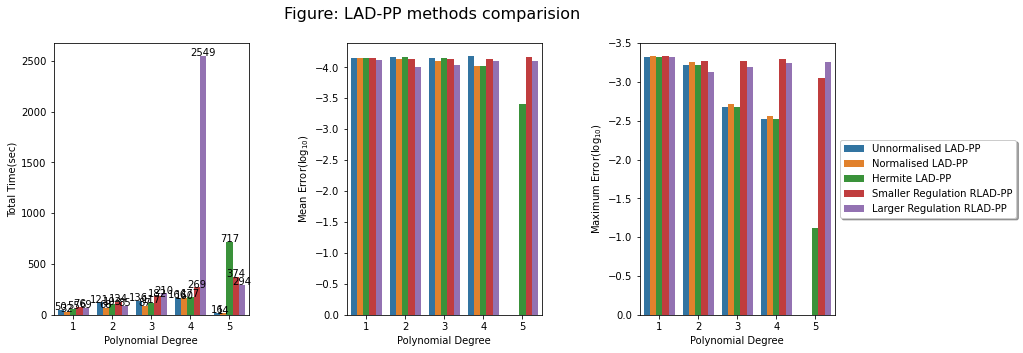

In [9]:
LAD_figure(result3)
# need to clean the time of unnormalised and normalised

Remarks regarding the graph

### Accuracy integration
---
Judd et al.(2011) emphasis the method of integration plays a deterministic role on the accuracy of simulation models. Following their discussion, we will be looking at three different types of methods: Monte-Carlo, Gauss-Hermite quadrature, and finally monomial. Accompanying the theoretical reasoning, I include the implementations of different integration methods under the GSSA framework. The results support the claim of Judd et al.(2011).


Monte-Carlo:

A $N$-node Monte-Carlo intergration draws $N$ numbers of shock $\{\epsilon_{t+1,j}\}_{j=1,...,N}$ and compute $y_{t}$ in equation (12). Notice that the shock $\epsilon_{t+1,j}$ differs from $\epsilon_{t+1}$, as the latter one describe the shock from the simulations (iterations). The integration can be expressed with $\varepsilon^{I}_{t}=y_{t}-E(\cdot)$ where the $E(\cdot)$ denotes the conditional expectation from equation (11). By substitution, we can express equation (14) as $\hat b = b + [(X)^{\top}(X)]^{-1}(X)^{\top}\varepsilon^{I}$, where $\varepsilon^{I}$ denotes $\{\varepsilon^{I}_{t}\}_{t=1,..,T}$. Assume $\{\varepsilon^{I}_{t}\}_{t=1,..,T}  \sim \mathcal{N}(0,\,\sigma^{2})$ are i.i.d., we finally arrive to the asymptotic distribution of the OLS estimator $\sqrt{TN}(\hat b - b) \sim \mathcal{N}(0,\,[X^{\top}X]^{-1}\sigma^{2})$. 

We draw a short conclusion from the distribution we just derived: In order to lower the error term, one must either raise the simulation length $T$ or the number of shocks $N$. Combined with the fact that Monte-Carlo has a slow convergence rate $\sqrt T$ (see Caflisch (1998)), it is impractical to achieve high accuracy with simulations method. For example, if we want to calculate a unit-free integration error defined as $\frac{y_{t}-E(\cdot)}{E(\cdot)}$, we will need a simulation length of 1,000,000 in order to lower the error to an average of $10^{-5}. 

Gauss-Hermite

Instead of drawing $N$ shocks, $N$-node Gauss hermite quadrature integration ($Q(n)$) approximates equation (12) from assigning $\epsilon_{t+1,j}$ with $N$ deterministic integration nodes $\nu$ and weights $\omega$:
$$
\begin{align*}
\int_{\mathbb{R^{N}}}G(\epsilon)\omega(\epsilon)d\epsilon  \approx \pi^{-N/2} \sum^{J_1}_{j1=1}...\sum^{J_N}_{jN=1}\omega^{1}_{j1}...\omega^{N}_{jN}G(\sqrt2 \Omega (\nu^{1}_{j},...,\nu^{N}_{jN})^{\top}) \tag{18}
\end{align*}
$$
Where $G(\cdot)$ in this case is our approximation function. For example, $\epsilon_{t+1,1}=0$ with a weight $\omega_{t+1,1}$ of 0 under $Q(1)$, while $\epsilon_{t+1,1}=-\sigma$ with a weight $\omega_{t+1,1}$ of $\frac{1}{2}$ under $Q(2)$. The complete mathematics derivation and the table of all weights and nodes for $Q(n)$ can be found at Judd (1998, p.261). The biggest advantage of $Q(n)$ is the accuracy it provides. Assuming the target function for approximation is continuous, $Q(n)$ decrease the error rapidly with more integration nodes added. The integration formula also relies on the degree of polynomials, which means it is possible to address the issue of higher polynomials do not yield better accuracy in the simulation methods with $Q(n)$. The drawback from this methods lies in the number of node constructions, in particular, $Q(n)$ is extremely costly for approximating over multidimension integrals. From equation (17) we can see that the total number of nodes are $J_1 \cdot J_2,...,J_N$. Assuming we want to estimate a multidimension case with $k$ agents, we will need to construct $(J_1 \cdot J_2,...,J_N)^{k}$ number of nodes.


Monomial

Monomial integration aims to deal with the exponential node problem from the $Q(n)$. The entire mathematic derivation of constructing a monomial formula to deal with multicollinearity is beyond the scope of this notebook. However, one can find a detailed explanation in the appendix of Judd et al. (2011) where they showcase the entire procedures. The advantage of Monomial integration rule is that it does not rely on the product of nodes, but rather the summation. This means that the cost only grows polynomially and not exponentially.

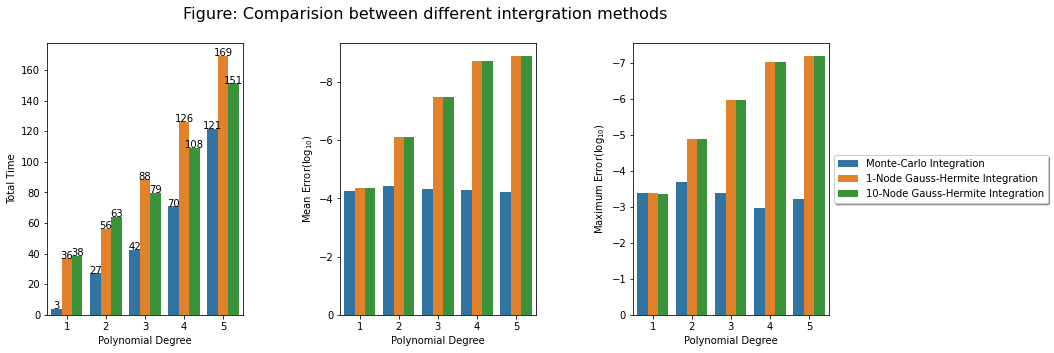

In [10]:
Figure4()

Remarks regarding the figures

### Country implementation

In this section, I will implement the GSSA into a multi-country setting, where the 

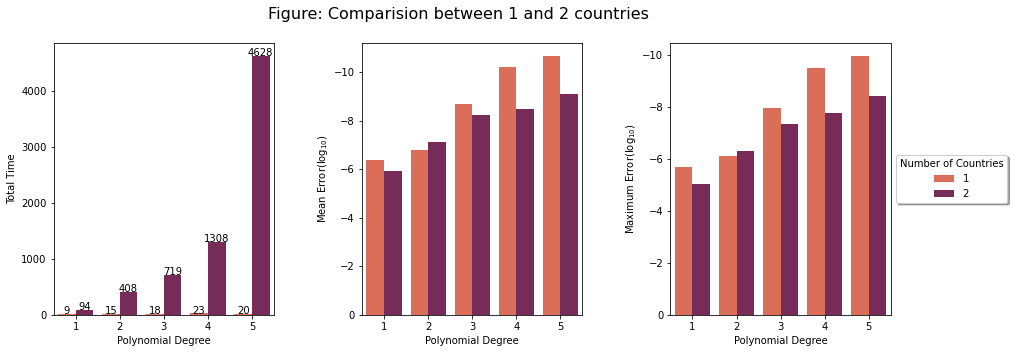

In [11]:
country_Figure1()

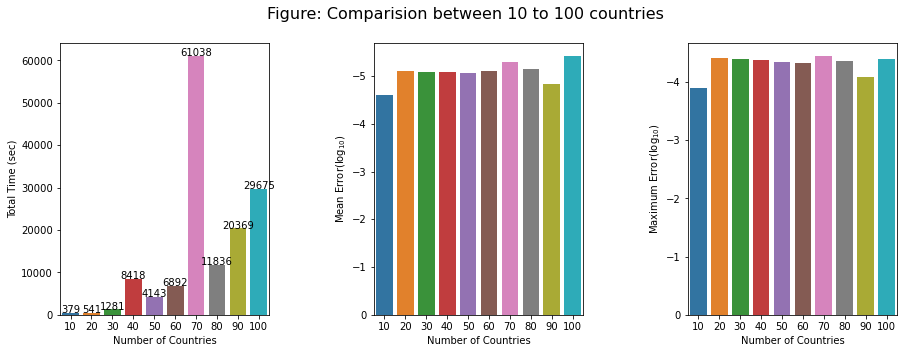

In [12]:
country_Figure2()

### Conclusion

### Reference

Caflisch, R. E. (1998). Monte carlo and quasi-monte carlo methods. Acta numerica, 1998, 1-49.

Maliar, L., & Maliar, S. (2003). Parameterized Expectations Algorithm and the Moving Bounds. Journal of Business & Economic Statistics, 21(1), 88-92.

Den Haan, W. J., & Marcet, A. (1990). Solving the stochastic growth model by parameterizing expectations. Journal of Business & Economic Statistics, 8(1), 31-34.

Judd, K., Maliar, L., & Maliar, S. (2011). One-node quadrature beats Monte Carlo: a generalized stochastic simulation algorithm (No. w16708). National Bureau of Economic Research.

Judd, K. L., & Judd, K. L. (1998). Numerical methods in economics. MIT press.
